In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from sklearn.preprocessing import StandardScaler
warnings.filterwarnings("ignore")

In [2]:
from sklearn.compose import ColumnTransformer
from sklearn.datasets import make_moons
from sklearn.impute import SimpleImputer 
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, VotingClassifier, RandomForestClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier, Pool
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from imblearn.under_sampling import TomekLinks

In [4]:
df = pd.read_csv('train.csv')
print('Original: {}'.format(df.shape))

Original: (35156, 22)


In [5]:
df_test = pd.read_csv('test.csv')
df_test['Weather'] = np.zeros((len(df_test),))

# 以 train_end_idx 作為 'train.csv' 和 'test.csv' 分界列，
train_end_idx = len(df)
df = pd.concat([df, df_test], sort=False)  

In [6]:
data_loc_lat = np.load('list_lat.npy',allow_pickle='TRUE').item()
data_loc_long = np.load('list_long.npy',allow_pickle='TRUE').item()
df['loc_lat']=df['Loc'].map(data_loc_lat)
df['loc_long']=df['Loc'].map(data_loc_long)

In [7]:
labelencoder = LabelEncoder()
date = df['Date']
data_loc = pd.get_dummies(df['Loc'])
data_loc = pd.DataFrame(data_loc)
data_WindDir = pd.get_dummies(df['WindDir'])
data_WindDir = pd.DataFrame(data_WindDir)
data_DayWindDir = pd.get_dummies(df['DayWindDir'])
data_DayWindDir = pd.DataFrame(data_DayWindDir)
data_NightWindDir = pd.get_dummies(df['NightWindDir'])
data_NightWindDir = pd.DataFrame(data_NightWindDir)
data_wind = data_WindDir + data_DayWindDir + data_NightWindDir
df = df.drop(columns = [col for col in df.columns if df[col].dtype == np.object])
df['Weather'] = df['Weather']*2-1

In [8]:
def preprocessor_time(text):
    ret=[0, 0, 0] 
    sp = text.split('/')
    ret[0]=int(sp[0])
    ret[1]=int(sp[1])
    ret[2]=int(sp[2])
    return ret

In [9]:
process_date=[]
for D in date:
    try:
        d=preprocessor_time(D)
        process_date.append(d)
    except:
        process_date.append([2012,6,2])
process_date=np.array(process_date)
data_date = PCA(n_components=3).fit_transform(process_date)
# df['d1']=data_date[:,0]
# df['d2']=data_date[:,1]
# df['d3']=data_date[:,2]
df['Y']=process_date[:,0]
df['M']=process_date[:,1]
df['D']=process_date[:,2]

In [10]:
data_wind = PCA(n_components=2).fit_transform(data_wind)
df['w1']=data_wind[:,0]
df['w2']=data_wind[:,1]

In [11]:
data_loc = PCA(n_components=2).fit_transform(data_loc)
df['l1']=data_loc[:,0]
df['l2']=data_loc[:,1]
# df['l3']=data_loc[:,2]

In [12]:
most_common = df.mode()
for feature in df.drop(columns = ['Weather']).columns:
    df[feature] = df[feature].fillna(df[feature].mean())
#     df[feature] = df[feature].fillna(most_common[feature].item())

In [13]:
# df_col = df.columns
# less_importance_feature = [24, 21, 22, 17, 18]
# for i in less_importance_feature:
#     df = df.drop(columns = [df_col[i]])
#     print(df_col[i])

In [14]:
df.head()

,TempLow,TempHigh,Steaming,Sun,WindSpeed,DayWindSpeed,NightWindSpeed,DayHumidity,NightHumidity,DayPressure,...,RISK_MM,loc_lat,loc_long,Y,M,D,w1,w2,l1,l2
0,19.5,23.741634,5.694960,0.500000,61.0,31.000000,22.000000,86.641375,41.810006,1020.400000,...,1.772145,-32.415048,141.595767,2016,7,19,-0.084133,-0.689081,-0.004442,-0.002218
1,2.1,15.700000,5.701668,5.700000,26.0,9.000000,7.000000,53.275715,76.598048,1023.700000,...,0.000000,-35.297591,149.101268,2010,7,26,-0.599154,-0.588789,0.928315,0.008584
2,20.9,36.100000,5.694960,8.003251,39.0,31.000000,17.000000,15.471574,52.163254,1017.100000,...,0.000000,-31.199914,136.825353,2014,4,2,-0.572725,0.788592,-0.053274,0.816967
3,11.5,23.900000,5.694960,7.993227,35.0,7.000000,17.000000,46.442398,67.664733,1010.200000,...,0.200000,-35.420977,149.092134,2014,11,19,0.352503,0.361175,-0.018196,-0.021029
4,8.2,20.500000,3.200000,8.003251,69.0,13.739091,18.424823,51.830889,51.770240,1018.043992,...,0.600000,-42.882509,147.328123,2012,6,2,1.268578,-0.562173,0.044926,-0.187193


# train

In [15]:
X_train, X_val, y_train, y_val = train_test_split(
    df.drop(columns = ['Weather']).values[:train_end_idx],
    df['Weather'].values[:train_end_idx], test_size=0.25, shuffle=True, random_state=42)
X_test = df.drop(columns = ['Weather']).values[train_end_idx:, :]

In [16]:
sc = StandardScaler()
sc.fit(X_train)
X_train = sc.transform(X_train)
X_val = sc.transform(X_val)
X_test = sc.transform(X_test)

In [17]:
# sm = SMOTE(random_state=42)
# X_train, y_train = sm.fit_resample(X_train, y_train)

In [18]:
tl = TomekLinks(sampling_strategy='majority')
X_train, y_train=tl.fit_resample(X_train, y_train)

In [19]:
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_test.shape)

(25800, 25)
(25800,)
(8789, 25)
(8789,)
(34844, 25)


In [35]:
model = LGBMClassifier(max_depth=12, 
                       n_estimators=300, 
                       scale_pos_weight=4, 
                       num_leaves=20,
                       )

model.fit(X_train, y_train)
# y_pred_decision = model.predict(X_train)
# print('f1-score: %f' % f1_score(y_train, y_pred_decision))
y_pred_decision = model.predict(X_val)
print('f1-score: %f' % f1_score(y_val, y_pred_decision))

f1-score: 0.473709


In [21]:
ans_pred = model.predict(X_test)
ans_pred = (ans_pred+1)/2
df_sap = pd.DataFrame(ans_pred.astype(int), columns = ['Weather'])
df_sap.to_csv('myAns.csv',  index_label = 'Id')

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

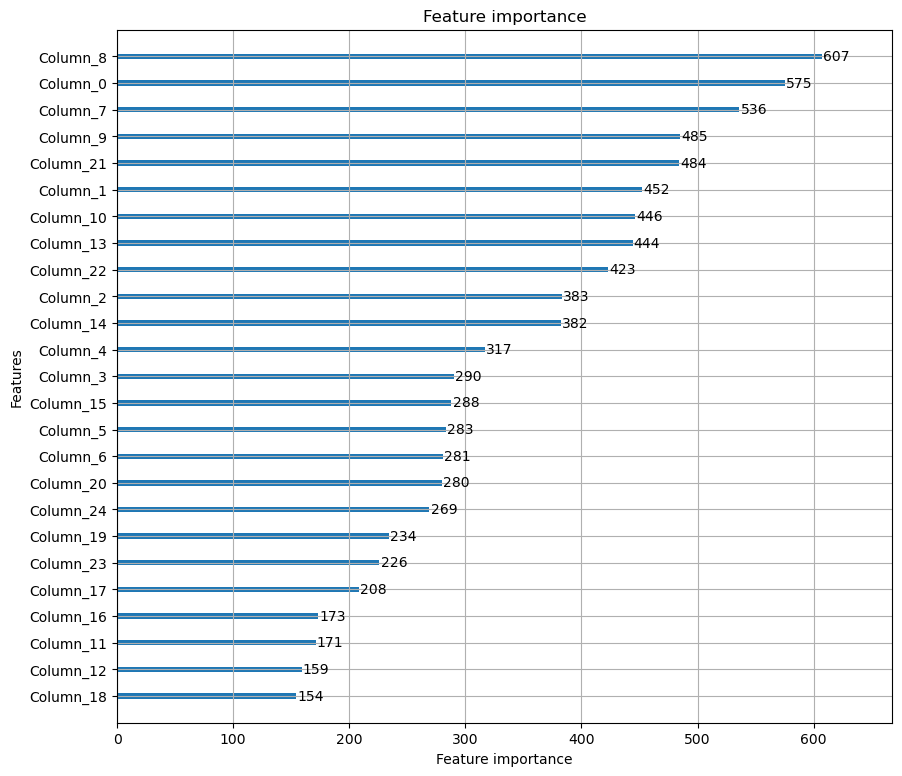

In [29]:
from lightgbm import LGBMClassifier, plot_importance 
plot_importance(model, figsize=(10, 9))

In [34]:
df.columns[21]

'D'

In [24]:
# less_importance_feature = [24, 21, 22, 18]
# for i in less_importance_feature:
#     print(df.columns[i])